# Building ML Web Apps: Part 1

## Table of Contents

1. Overview
2. Tools
3. Architecture
4. Front-End
5. ML Model
6. ML Microservices
    - Music Generator
    - Visualizations
    - Audio Effects
    - Midi Representation
7. Testing
8. Concluding Thoughts
9. Exercise

## 1. Overview

## 2. Tools

- MLServer
- Gradio
- Transformers
- 

## 3. Architecture

## 4. Front-End

## 5. ML Model
    - AudioLDM2
    - MusicGen

In [31]:
from IPython.display import Audio
from transformers import AutoProcessor, MusicgenForConditionalGeneration
from diffusers import AudioLDM2Pipeline
import torch

In [32]:
processor = AutoProcessor.from_pretrained("facebook/musicgen-small")
model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small")

/home/ramonperez/mambaforge/envs/ml_svcs_p2/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [41]:
inputs = processor(
    text=["fast bachata with high quality in the style of juan luis guerra"],
    padding=True,
    return_tensors="pt",
)

In [42]:
sampling_rate = model.config.audio_encoder.sampling_rate
sampling_rate

32000

In [43]:
audio_values = model.generate(**inputs, do_sample=True, guidance_scale=3, max_new_tokens=256)

In [44]:
audio_values.shape

torch.Size([1, 1, 161920])

📈👀 👌

In [45]:
audio_values[0, 0].numpy().shape

(161920,)

In [8]:
Audio(audio_values[1].numpy(), rate=sampling_rate)

In [9]:
import librosa

In [10]:
y_har, y_per = librosa.effects.hpss(audio_values[1].numpy())

In [12]:
Audio(y_per, rate=sampling_rate)

Get as creative as possible with the following prompt. 😎

In [30]:
prompt = "fast bachata with high quality"

In [ ]:
music = musicgen(prompt, forward_params={"do_sample": True, "max_new_tokens":250})
music

In [28]:
Audio(music['audio'][0], rate=music['sampling_rate'])

Testing AudioLDM2

In [3]:
prompt = "The vibrant beat of Brazilian samba drums."

In [4]:
audio = pipe(prompt, num_inference_steps=100, audio_length_in_s=7.0)

  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
audio

AudioPipelineOutput(audios=array([[-0.00210865, -0.0028956 , -0.00796783, ..., -0.04761124,
        -0.06677017, -0.09066533]], dtype=float32))

In [8]:
Audio(audio.audios[0], rate=16000)

In [2]:
from pedalboard import Pedalboard, Distortion, Delay, Reverb
from pedalboard.io import AudioFile

In [7]:
with AudioFile("brazilian_noise.mp3", "r") as f:
    song = f.read(f.frames)
    print(f.samplerate)
song

16000


array([[ 0.0000000e+00, -1.2362391e-11,  1.6470237e-11, ...,
        -4.6206828e-06, -6.0318525e-06, -7.7740970e-06]], dtype=float32)

In [4]:
song.shape

(1, 113472)

In [8]:
Audio(song, rate=16000)

In [21]:
board = Pedalboard([
    Distortion(drive_db=10),
    Delay(delay_seconds=1, feedback=0.1, mix=0.1),
    Reverb(room_size=0.10)
])

In [22]:
new_song = board(song, sample_rate=16000)

In [23]:
Audio(new_song, rate=16000)

In [10]:
with AudioFile("brazilian_noise.mp3", "w", samplerate=16000, num_channels=1) as f:
    f.write(audio.audios[0])

In [ ]:
audio = pipe(
        prompt,
        audio_length_in_s=10.0,
        guidance_scale=guidance_scale,
        num_inference_steps=200,
        negative_prompt="low quality",
        num_waveforms_per_prompt=n_candidates if n_candidates else 1,
        generator=generator.manual_seed(int(random_seed)),
)["audios"]

## 6. ML Microservices

Time to get our service up and running.

In [46]:
%%writefile servers/ml_model/ml_service.py

from transformers import AutoProcessor, MusicgenForConditionalGeneration
from mlserver.codecs import decode_args
from mlserver import MLModel
from typing import List
import numpy as np

Writing src/ml_services.py


In [47]:
%%writefile -a servers/ml_model/ml_service.py

MUSICGEN = "facebook/musicgen-small"

class MusicGenServer(MLModel):
    async def load(self):
        self.processor = AutoProcessor.from_pretrained(MUSICGEN)
        self.model     = MusicgenForConditionalGeneration.from_pretrained(MUSICGEN)

    @decode_args
    async def predict(self, text: List[str], guidance_scale: np.ndarray, max_new_tokens: np.ndarray) -> np.ndarray:
        inputs = self.processor(text=text, padding=True, return_tensors="pt")
        audio_values = self.model.generate(
            **inputs, do_sample=True, guidance_scale=guidance_scale[0][0], max_new_tokens=max_new_tokens[0][0]
        ).numpy()
        sampling_rate = self.model.config.audio_encoder.sampling_rate
        return audio_values[0]

Appending to src/ml_services.py


In [ ]:
%%writefile servers/ml_model/model-settings.json
{
    "name": "KullModel"
    "implementation": "ml_service.MusicGenServer"
}

In [245]:
from mlserver.codecs import StringCodec, NumpyCodec
import numpy as np
import requests

In [103]:
NumpyCodec.encode_input(name='guidance', payload=np.array([5])).dict()

{'name': 'guidance',
 'shape': [1, 1],
 'datatype': 'INT64',
 'parameters': {'content_type': 'np'},
 'data': [5]}

In [65]:
song_i_want = StringCodec.encode_input(
    name='text', payload=['slow bachata with violin sounds'], use_bytes=False
).dict()

In [66]:
input_request = {
    'inputs': [song_i_want]
}
endpoint = "http://localhost:8080/v2/models/musicgen_model/infer"

In [67]:
input_request

{'inputs': [{'name': 'text',
   'shape': [1, 1],
   'datatype': 'BYTES',
   'parameters': {'content_type': 'str'},
   'data': ['slow bachata with violin sounds']}]}

In [68]:
result = requests.post(endpoint, json=input_request)
result

<Response [200]>

In [72]:
Audio(result.json()['outputs'][0]['data'], rate=sampling_rate)

In [195]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

In [196]:
def plot_waveform(waveform, sample_rate):
    # waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = np.arange(0, num_frames) / sample_rate

    figure = Figure() 
    axes = figure.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    return figure

In [222]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    # waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    figure = Figure() 
    axes = figure.subplots(num_channels, 1)
    # figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    return figure

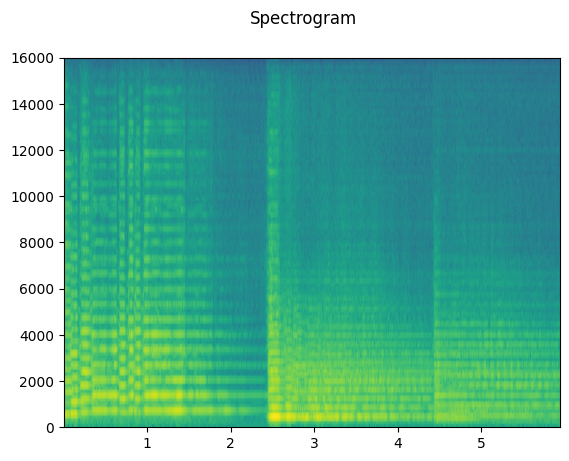

In [227]:
plot_specgram(np.array([result.json()['outputs'][0]['data']]), sampling_rate)

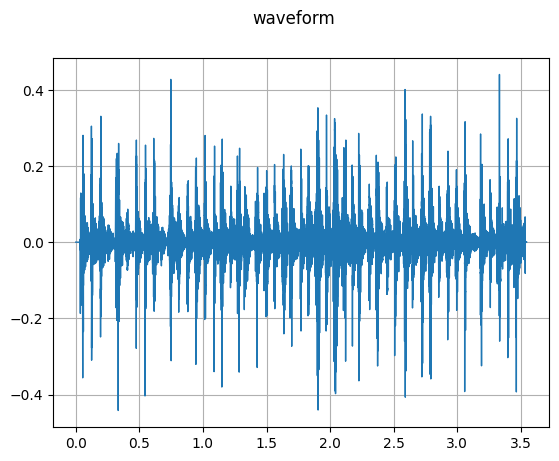

In [218]:
plot_waveform(song, sampling_rate)

In [ ]:
result.json()

In [105]:
type(result.json()['outputs'][0]['data'])

list

In [228]:
from pedalboard import load_plugin

In [231]:
eff = load_plugin("excite_cymbal/excite_cymbal.vst3/")

In [235]:
song.shape

(1, 113472)

In [238]:
song_dos = np.array([song[0], song[0]])
song_dos.shape

(2, 113472)

In [240]:
assert eff.is_effect

AssertionError: 

In [239]:
song_new = eff.process(input_array=song_dos, sample_rate=sampling_rate)

ValueError: Plugin 'EXC!TE Cymbal' does not accept audio input. It may be an instrument plugin instead of an effect plugin.

In [241]:
%%writefile servers/pedal_board/audio_mixer.py

from mlserver import MLModel
from pedalboard import Pedalboard, Distortion, Delay, Reverb, Chorus, Gain, PitchShift, Compressor, Mix
from pedalboard.io import AudioFile
from mlserver.codecs import decode_args
from typing import List, Optional
import numpy as np
from pydantic import BaseModel


# class AudioSettings(BaseModel):
#     song: np.ndarray
#     sample_rate: int
#     drive_db
#     delay_seconds
#     feedback
#     mix
#     room_size

class AudioMixer(MLModel):
    async def load(self):
        self.check = True

    @decode_args
    async def predict(
        self, 
        song: np.ndarray, 
        sample_rate: np.ndarray,
        # db: List[str], 
        # delay: Optional[np.ndarray] = 5, 
    ) -> np.ndarray:
        # self.board = Pedalboard([
        #     Distortion(drive_db=10), Delay(delay_seconds=1, feedback=0.1, mix=0.1),
        #     Reverb(room_size=0.10), Chorus(), Gain(), PitchShift()
        # ])

        passthrough = Gain(gain_db=0)

        delay_and_pitch_shift = Pedalboard([
            Delay(delay_seconds=0.25, mix=1.0), PitchShift(semitones=7), Gain(gain_db=-3),
        ])

        delay_longer_and_more_pitch_shift = Pedalboard([
            Delay(delay_seconds=0.5, mix=1.0), PitchShift(semitones=12), Gain(gain_db=-6),
        ])

        self.board = Pedalboard([
            # Put a compressor at the front of the chain:
            Compressor(),
            # Run all of these pedalboards simultaneously with the Mix plugin:
            Mix([
                passthrough, delay_and_pitch_shift, delay_longer_and_more_pitch_shift
            ]),
            # Add a reverb on the final mix:
            Reverb()
        ])
        self.new_audio = self.board(song, sample_rate=sample_rate[0][0])
        return self.new_audio


Writing servers/pedal_board/audio_mixer.py


In [243]:
%%writefile servers/pedal_board/model-settings.json
{
    "name": "novice_dj",
    "implementation": "audio_mixer.AudioMixer"
}

Writing servers/pedal_board/model-settings.json


In [244]:
%%writefile servers/pedal_board/settings.json
{
    "http_port": 7050,
    "grpc_port": 7060,
    "metrics_port": 6050
}

Writing servers/pedal_board/settings.json


In [247]:
song.shape

(1, 113472)

In [248]:
new_music = {
    "inputs": [
        NumpyCodec.encode_input(name='song', payload=song).dict(),
        NumpyCodec.encode_input(name='sample_rate', payload=np.array([32000])).dict()
    ]
}

In [249]:
import json 

data = {"x": [1, 2, 3, 4, 5], "y": [2, 4, 6, 8, 10]}
response = requests.post("http://localhost:7050/v2/models/novice_dj/infer", json=new_music)
print(response)

# fig_json = response.json()

# fig = json.loads(fig_json)
# plt.figure(fig) # Render figure

<Response [200]>


In [252]:
Audio(song, rate=sampling_rate)

In [251]:
Audio(response.json()['outputs'][0]['data'], rate=sampling_rate)

In [255]:
from glob import glob
import os
files =  glob("./music/*.mp3")
latest_file = max(files, key=os.path.getctime)
latest_file

'./music/brazilian_noise.mp3'

In [256]:
with AudioFile(latest_file, "r") as f:
    waveform = f.read(f.frames)
    sample_rate = f.samplerate

In [258]:
waveform.shape

(1, 113472)

In [259]:
sample_rate

16000